In [6]:
# ALL imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Create the Dataframes test_data and train_data of the respective data sets.
test_data = pd.read_csv('https://raw.githubusercontent.com/vgorrepa/Big_Data_Final_Project/main/drugsComTest_raw.csv')
train_data = pd.read_csv('https://raw.githubusercontent.com/vgorrepa/Big_Data_Final_Project/main/drugsComTrain_raw.csv')

# Get header information for train_data
train_data.head()


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [7]:
# Get header information for test_data
test_data.head()


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [9]:
print("Train shape :" ,train_data.shape)
print("Test shape :", test_data.shape)
print("Train Set / Test Set", train_data.values.shape[0]/test_data.values.shape[0])

Train shape : (161297, 7)
Test shape : (53766, 7)
Train Set / Test Set 2.999981400885318


 Here it can be seen that the both the Train and Test Data sets have 6 variables and 1 unique id 
 Train Data set is ~ 3 times larger than the Test Data set.

In [13]:
test_data.dtypes


uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

In [14]:
train_data.dtypes

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object



**Data Overview**
A patient with a unique ID purchases a drug that meets his or her condition and subsequently writes a review, provides a rating for the drug he/she purchased on the date. later on, if the other users read that review and find it helpful, they will click usefulCount, which will add 1 for the variable hence increasing the usefulCount.

**Data Types**
drugName (categorical): name of the drug
condition (categorical): name of the condition
review (text): patient's review
rating (numerical): 10 star patient's rating
date (date): date of review entry
usefulCount (numerical): number of users who found review useful


In [17]:
conditions = train_data.condition.value_counts().sort_values(ascending=False)
conditions[:15]

Birth Control                28788
Depression                    9069
Pain                          6145
Anxiety                       5904
Acne                          5588
Bipolar Disorde               4224
Insomnia                      3673
Weight Loss                   3609
Obesity                       3568
ADHD                          3383
Diabetes, Type 2              2554
Emergency Contraception       2463
High Blood Pressure           2321
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2096
Name: condition, dtype: int64

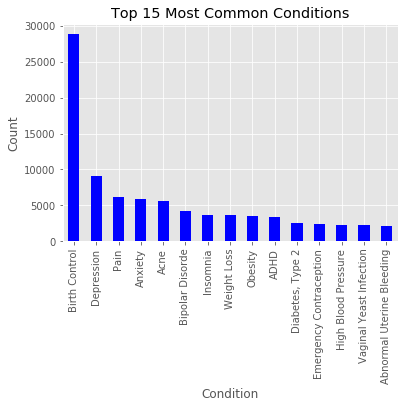

In [20]:
conditions[:15].plot(kind='bar',color ='blue')
plt.title('Top 15 Most Common Conditions')
plt.xlabel('Condition')
plt.ylabel('Count');

Text(0.5, 1.0, 'Count of rating values Train Data')

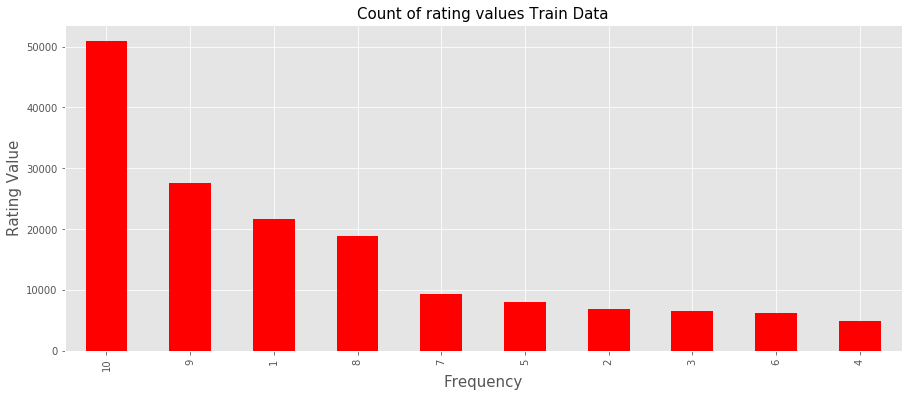

In [27]:
rating = train_data['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (15,6), fontsize = 10,color="red")
plt.xlabel("Frequency", fontsize = 15)
plt.ylabel("Rating Value", fontsize = 15)
plt.title("Count of rating values Train Data", fontsize = 15)

Text(0.5, 1.0, 'Count of rating values Test Data')

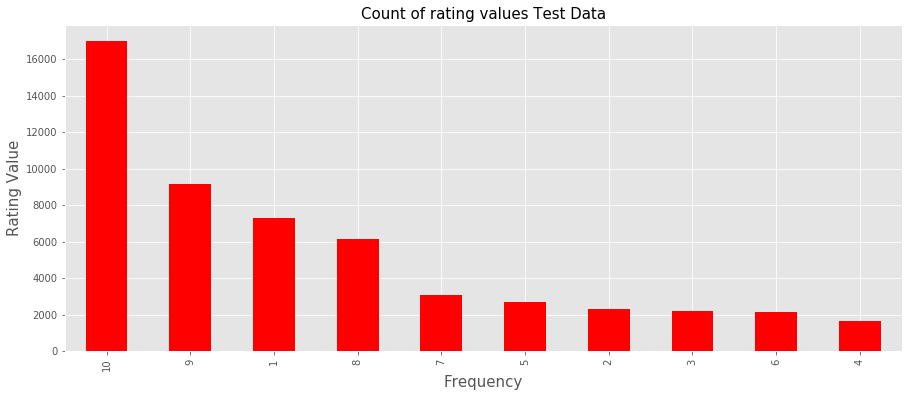

In [28]:
rating = test_data['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (15,6), fontsize = 10,color="red")
plt.xlabel("Frequency", fontsize = 15)
plt.ylabel("Rating Value", fontsize = 15)
plt.title("Count of rating values Test Data", fontsize = 15)